### <font color = 'blue'> Lectura de datos


In [49]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np , seaborn as sns

In [50]:
# Búlbo seco
ts_0 = pd.read_excel('/content/Datos_micro_p1.xlsx', sheet_name='BULBO SECO',usecols=[1, 2], header = 1).dropna()
ts_30 = pd.read_excel('/content/Datos_micro_p1.xlsx', sheet_name='BULBO SECO', usecols=[3, 4], header = 1).dropna()
ts_50 = pd.read_excel('/content/Datos_micro_p1.xlsx', sheet_name='BULBO SECO', usecols=[5, 6], header = 1).dropna()
ts_100 = pd.read_excel('/content/Datos_micro_p1.xlsx', sheet_name='BULBO SECO', usecols=[7, 8], header = 1).dropna()
ts_160 = pd.read_excel('/content/Datos_micro_p1.xlsx', sheet_name='BULBO SECO', usecols=[9, 10], header = 1).dropna()
ts_0.columns = ['T', 'R']; ts_30.columns = ['T', 'R']; ts_50.columns = ['T', 'R']; ts_100.columns = ['T', 'R']; ts_160.columns = ['T', 'R']

# Búlbo húmedo
th_0 = pd.read_excel('/content/Datos_micro_p1.xlsx', sheet_name='BULBO HÚMEDO',usecols=[1, 2], header = 1).dropna()
th_30 = pd.read_excel('/content/Datos_micro_p1.xlsx', sheet_name='BULBO HÚMEDO', usecols=[3, 4], header = 1).dropna()
th_50 = pd.read_excel('/content/Datos_micro_p1.xlsx', sheet_name='BULBO HÚMEDO', usecols=[5, 6], header = 1).dropna()
th_100 = pd.read_excel('/content/Datos_micro_p1.xlsx', sheet_name='BULBO HÚMEDO', usecols=[7, 8], header = 1).dropna()
th_160 = pd.read_excel('/content/Datos_micro_p1.xlsx', sheet_name='BULBO HÚMEDO', usecols=[9, 10], header = 1).dropna()
th_0.columns = ['T', 'R']; th_30.columns = ['T', 'R']; th_50.columns = ['T', 'R']; th_100.columns = ['T', 'R']; th_160.columns = ['T', 'R']

In [47]:
th_30.head(3)

,T,R
0,56.5,151.0
1,55.0,159.0
2,54.0,166.0


### <font color = 'blue'> Función de calibración
Se crea una clase, este recibirá como argumento el dataframe con las columnas 'T' y 'R',  en ese orden y con ese nombre.

In [51]:
class term_cal:
  # ___________________________________________________________________
  # |__Nombre___|_______________Descripción_____________|___Variable___|
  # |....tab....|Dataframe con datos completos (sin NA).|...DATAFRAME..|
  # |...........|..........columnas:.[T, R].............|..............|
  # |....fix....|Activa la corrección por error relativo|...Boolean....|
  # |Err_rel_max|Cota del error relativo tolerable......|....float-....|
  # ===================================================================

  def __init__(self, tab, fix = False, Err_rel_max = 0.03):
    self.tab = tab; self.fix = fix; self.Err_rel_max = Err_rel_max

    # Importar librerías
    import pandas as pd, matplotlib.pyplot as plt, numpy as np , seaborn as sns
    from sklearn.linear_model import LinearRegression

    # Preprocesamiento 
    self.LnR = pd.Series([np.log(x) for x in tab['R']]).to_numpy()[:, np.newaxis]

    # Regresión lineal (I)
    lr = LinearRegression()
    lr.fit(self.LnR, self.tab['T']+273.15)
    self.R2 = lr.score(self.LnR, self.tab['T']+273.15)
    self.A = lr.intercept_; self.B = (-1)*lr.coef_
    self.tab['T_est'] = [self.A - self.B*np.log(x) - 273.15 for x in self.tab['R']]
    print(f'La ecuación de regresión es: T = {self.A} - {self.B[0]}.Ln(R)')

    # Corrección de error relativo
    self.tab['Err_rel'] = abs((self.tab['T_est']-self.tab['T'])*100/(self.tab['T']+273.15))
    mean_err = self.tab['Err_rel'].mean()[0]
    print(f'El error relativo promedio es: {mean_err:.4f}%\n')
    err = self.tab[self.tab['Err_rel']>=self.Err_rel_max*100]
    err.sort_values(by = 'Err_rel', ascending = False)

    if self.fix == False:
      if err.shape[0] != 0:
        print(f'¡Advertencia! Se han detectado {err.shape[0]} datos con error relativo mayor o igual a {self.Err_rel_max*100}')
        print('Recomendación: Realizar corrección por error relativo. Intentar con fix = True')
    
    elif self.fix == True:
      if err.shape[0] == 0: print('No se encuentran estimaciones con errores relativos significativos.')
      elif err.shape[0] != 0 and self.tab.shape[0] >= 30:
        while self.tab.shape[0] >= 30 and err.shape[0] != 0:
          # Regresión lineal (II)
          self.LnR = pd.Series([np.log(x) for x in tab['R']]).to_numpy()[:, np.newaxis]
          lr.fit(self.LnR, self.tab['T']+273.15)
          self.R2 = lr.score(self.LnR, self.tab['T']+273.15); self.A = lr.intercept_; self.B = (-1)*lr.coef_
          self.tab['T_est'] = [self.A - self.B*np.log(x) for x in self.tab['R']]
          self.tab['Err_rel'] = abs((self.tab['T_est'] - self.tab['T'])*100/(self.tab['T']+273.15))
          err = self.tab[self.tab['Err_rel']>=self.Err_rel_max*100]
          self.tab.drop(self.tab[self.tab['Err_rel'].astype(float) == float(err.head(1)['Err_rel'])].index, inplace=True)

          if err.shape[0]>=1:
            err = self.tab[self.tab['Err_rel']>=self.Err_rel_max*100]
            err.sort_values(by = 'Err_rel', ascending = False)
          else: err = pd.DataFrame()

      mean_err = self.tab['Err_rel'].mean()[0]
      print(f'El error relativo promedio es: {mean_err:.4f}%')
      print(f'La ecuación de regresión es: T = {self.A} - {self.B[0]}.Ln(R)')

    # Gráfica
    fig, ax = plt.subplots(1, 1, figsize = (8,5))
    ax.set_title('Regresión lineal')
    ax.plot(self.tab['R'], self.tab['T'], 'b-', alpha = 0.75)
    ax.plot(self.tab['R'], self.tab['T_est'], 'r-', alpha = 0.75)
    ax.legend(['Observado', 'Estimado'])
    plt.show()

  def Fisher_test(self, alpha):
    # Ho: A y B = 0
    # H1: A y B != 0

    from scipy.stats import f
    q, n1, n2 = 1-alpha, 2, self.tab.shape[0]   # alpha, P, N
    self.F_cal = self.R2/(1-self.R2)*(n2 - n1 - 1)/n1
    self.F_t = f.ppf(q = q, dfn = n1, dfd = n2)

    print(f'F calculado = {self.F_cal:.4f}\nF teórico = {self.F_t:.4f}\n')

    # Gráfica
    fig, ax = plt.subplots(1, 1, figsize = (8,5))
    ax.set_title('Distribución de Fisher')
    x = np.linspace(f.ppf(0.01, n1, n2), f.ppf(0.99, n1, n2), 100)
    ax.plot(x, np.full(100, 0), 'k-', lw=1); ax.plot(x,f.pdf(x, n1, n2),'k-',lw=2,alpha=0.75)
    ax.fill_between(x[x>f.ppf(q, n1, n2)], y1 = 0, y2 = f.pdf(x[x>f.ppf(q, n1, n2)], n1, n2))
    plt.show()

    if self.F_cal > self.F_t:
      print(f"""\nA un nivel de significación de {alpha}, 
existe suficiente evidencia estadística para rechazar Ho.""")
      print('Por lo que, A y B son diferentes a cero')
    elif self.F_cal < self.F_t:
      print(f"""\nA un nivel de significación de {alpha}, 
existe suficiente evidencia estadística para aceptar Ho.""")
      print('Por lo que, A, B o ambos son iguales cero')


  def Fisher_multitest(self, alpha):
    self.alpha = alpha  # alpha es una lista
    from scipy.stats import f
    fig, ax = plt.subplots(1, 1, figsize = (8,5))
    F_t = []; test = []; color = ['yellow', 'blue', 'red', 'black', 'green']
    for i in range(len(alpha)):
      q, n1, n2 = 1-alpha[i], 2, self.tab.shape[0]   # alpha, P, N
      F_cal=self.R2/(1-self.R2)*(n2 - n1 - 1)/n1
      F_t.append(f.ppf(q = q, dfn = n1, dfd = n2))
      
      x = np.linspace(f.ppf(0.01, n1, n2), f.ppf(0.99, n1, n2), 100)
      ax.fill_between(x[x>f.ppf(q, n1, n2)], y1 = 0, y2 = f.pdf(x[x>f.ppf(q, n1, n2)], n1, n2),
                      alpha = 0.45, color = color[i], label = f'{alpha[i]}')
      
      if F_cal > F_t[i]:   test.append(True)
      elif F_cal < F_t[i]: test.append(False)
    ax.legend(title = 'Alpha')
    ax.plot(x, np.full(100, 0), 'k-', lw=1); ax.plot(x,f.pdf(x, n1, n2),'k-',lw=2,alpha=0.45)
    Fisher_test = pd.DataFrame({'alpha': alpha, 'F teórico': F_t, 'Ho': test})

    print(f'El estadítico de Fisher es igual a: {F_cal:.4f}\n')
    print(Fisher_test); plt.show()
    Ho_true=Fisher_test[Fisher_test['Ho']==True]
    a = ', '.join(Ho_true['alpha'].astype(str))
    if len(Ho_true)!=0:
      print('\nA un nivel de significación de ' + a) 
      print('existe suficiente evidencia estadística para rechazar Ho.')
      print('Por lo que, A y B son diferentes a cero')
    else: print('Para el otro ciclo será')

### <font color = 'blue'> Calibración de termistores

La ecuación de regresión es: T = 480.6309051532774 - 29.133241684446034.Ln(R)
El error relativo promedio es: 0.2082%

No se encuentran estimaciones con errores relativos significativos.
El error relativo promedio es: 0.2082%
La ecuación de regresión es: T = 480.6309051532774 - 29.133241684446034.Ln(R)


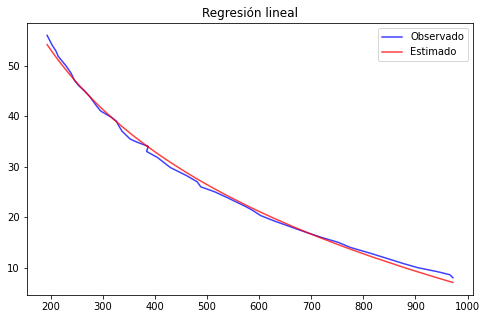

In [74]:
Oth_160 = term_cal(tab=th_160, fix = True, Err_rel_max=0.03)

El estadítico de Fisher es igual a: 7260.0552

   alpha  F teórico    Ho
0   0.10   2.424529  True
1   0.05   3.204317  True
2   0.01   5.110318  True


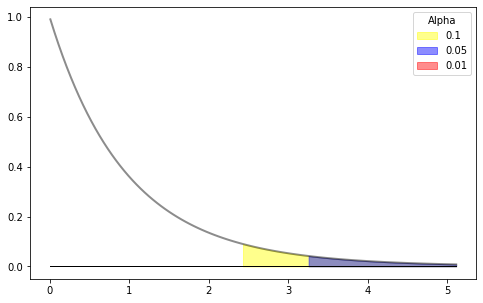


A un nivel de significación de 0.1, 0.05, 0.01
existe suficiente evidencia estadística para rechazar Ho.
Por lo que, A y B son diferentes a cero


In [75]:
Oth_160.Fisher_multitest(alpha = [0.1, 0.05, 0.01])

F calculado = 1849.4212
F teórico = 3.1951



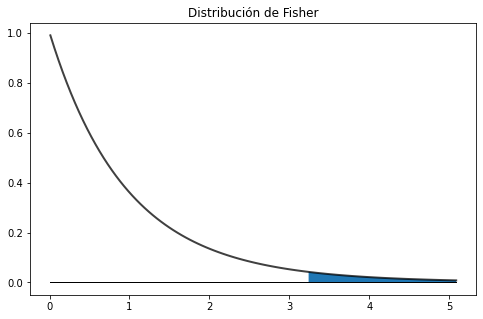


A un nivel de significación de 0.05, 
existe suficiente evidencia estadística para rechazar Ho.
Por lo que, A y B son diferentes a cero


In [ ]:
Ots_0.Fisher_test(alpha = 0.05)

La ecuación de regresión es: T = 784.6689526865541 - 68.58644628940823.Ln(R)
El error relativo promedio es: 0.7475%

No se encuentran estimaciones con errores relativos significativos.
El error relativo promedio es: 0.7475%
La ecuación de regresión es: T = 784.6689526865541 - 68.58644628940823.Ln(R)


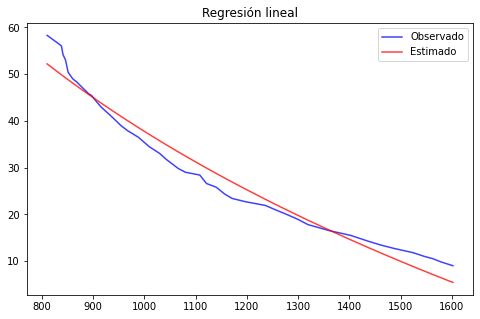

In [ ]:
Ots_30 = term_cal(tab=ts_30, fix = True, Err_rel_max=0.03)

F calculado = 1849.4212
F teórico = 3.1951



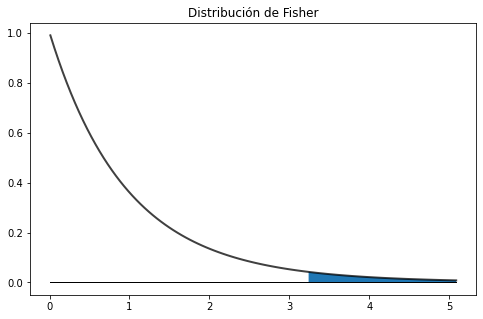


A un nivel de significación de 0.05, 
existe suficiente evidencia estadística para rechazar Ho.
Por lo que, A y B son diferentes a cero


In [ ]:
Ots_30.Fisher_test(alpha = 0.05)

La ecuación de regresión es: T = 769.6115125939066 - 66.395994467523.Ln(R)
El error relativo promedio es: 0.6456%

No se encuentran estimaciones con errores relativos significativos.
El error relativo promedio es: 0.6456%
La ecuación de regresión es: T = 769.6115125939066 - 66.395994467523.Ln(R)


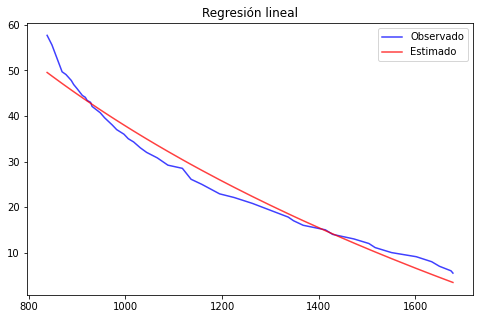

In [ ]:
Ots_50 = term_cal(tab=ts_50, fix = True, Err_rel_max=0.03)

F calculado = 706.4818
F teórico = 3.2093



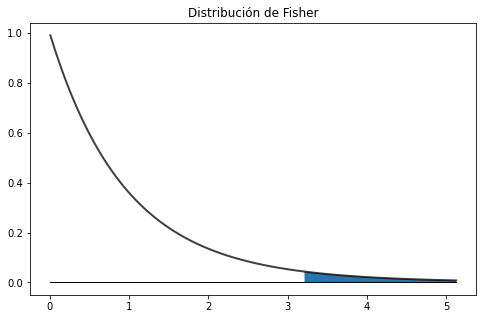


A un nivel de significación de 0.05, 
existe suficiente evidencia estadística para rechazar Ho.
Por lo que, A y B son diferentes a cero


In [ ]:
Ots_50.Fisher_test(alpha = 0.05)

La ecuación de regresión es: T = 748.3870684193623 - 63.290556769110935.Ln(R)
El error relativo promedio es: 0.6121%

No se encuentran estimaciones con errores relativos significativos.
El error relativo promedio es: 0.6121%
La ecuación de regresión es: T = 748.3870684193623 - 63.290556769110935.Ln(R)


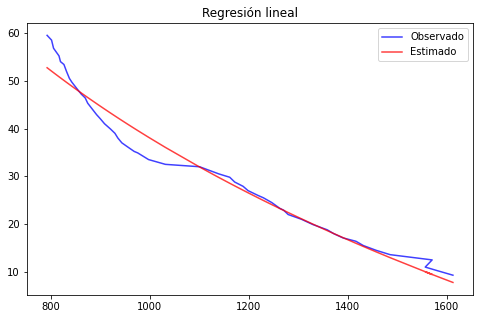

In [ ]:
Ots_100 = term_cal(tab=ts_100, fix = True, Err_rel_max=0.03)

F calculado = 635.1524
F teórico = 3.1788



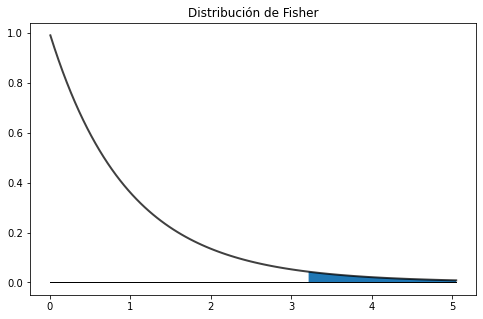


A un nivel de significación de 0.05, 
existe suficiente evidencia estadística para rechazar Ho.
Por lo que, A y B son diferentes a cero


In [ ]:
Ots_100.Fisher_test(alpha = 0.05)